In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

from src.models.unet.unet_model import UNet
# from models.basic_axial.basic_axialnet import BasicAxial, AxialUNet, AxialUNetSmall
# from models.basic_pga.basic_pga_net import BasicAxialPGA
from src.models.lbcnn.axial_lbcnn import BasicAxialLBC, BasicAxialLBC_Add, AxialUNetLBC, SmallAxialUNetLBC#, TinyAxialUNetLBC
from src.datasets.ice import Ice, IceWithProposals, BasicDatasetIce
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
from src.metrics.utils import display_metric_list

import matplotlib.pyplot as plt
import time

import os

In [2]:
data_dir = '/home/dsola/repos/PGA-Net/data/'
img_scale = .35
img_crop = 320
batch_size = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

test_set = Ice(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
                  os.path.join(data_dir, 'txt_files'), 'test', img_scale, img_crop)
test_loader = DataLoader(test_set, batch_size=1)

Image finished in 0.37541818618774414 seconds.
0.37541818618774414
Image finished in 0.23324990272521973 seconds.
0.6086680889129639
Image finished in 0.23224377632141113 seconds.
0.840911865234375
Image finished in 0.23378252983093262 seconds.
1.0746943950653076
Image finished in 0.29192423820495605 seconds.
1.3666186332702637
Image finished in 0.2344505786895752 seconds.
1.6010692119598389


<ipython-input-3-b9775d235106>:48: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(1,3, figsize=(15,15))


Image finished in 0.22651195526123047 seconds.
1.8275811672210693
Image finished in 0.23004961013793945 seconds.
2.057630777359009
Image finished in 0.2236769199371338 seconds.
2.2813076972961426
Image finished in 0.2971780300140381 seconds.
2.5784857273101807


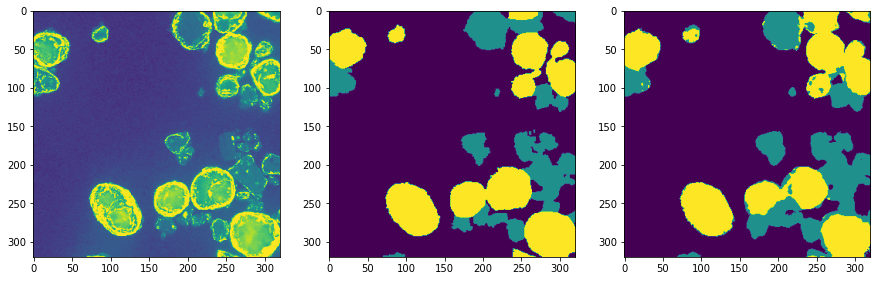

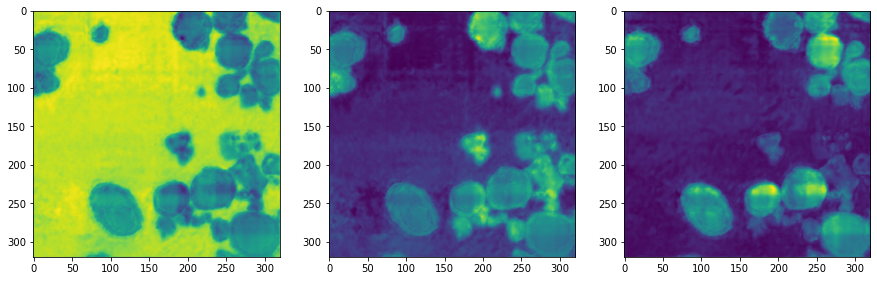

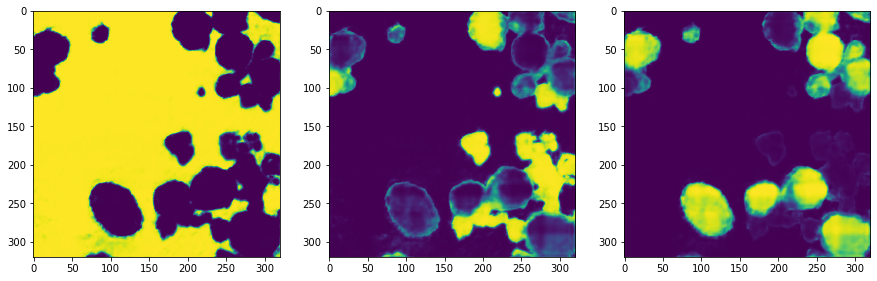

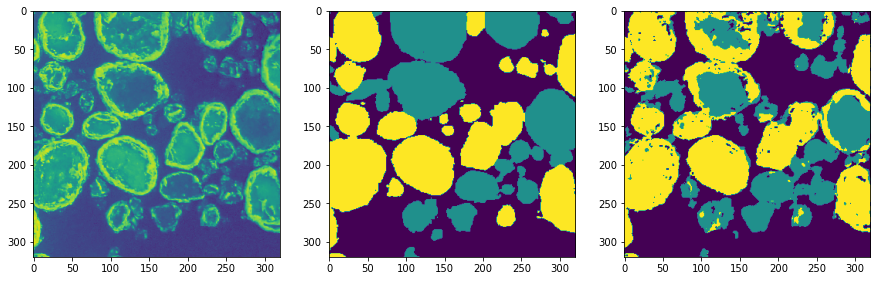

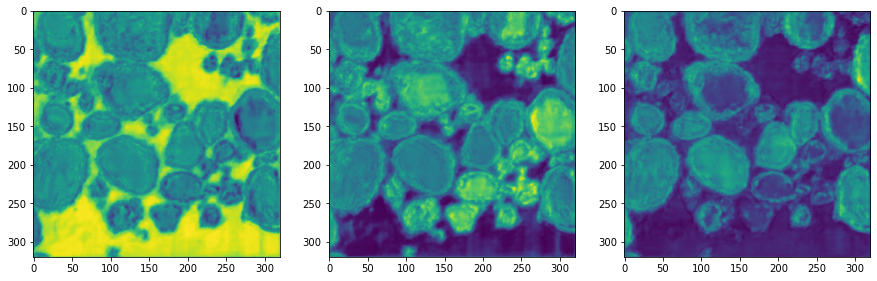

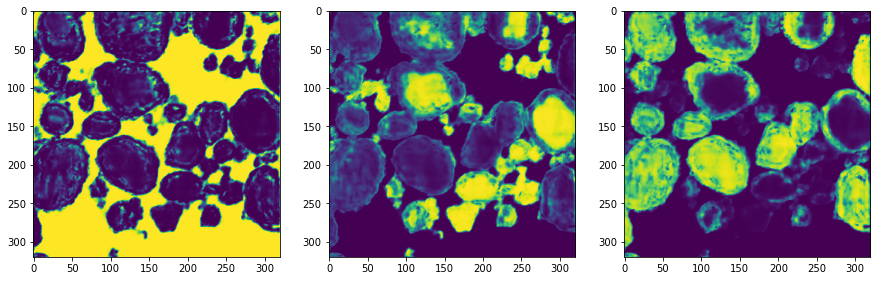

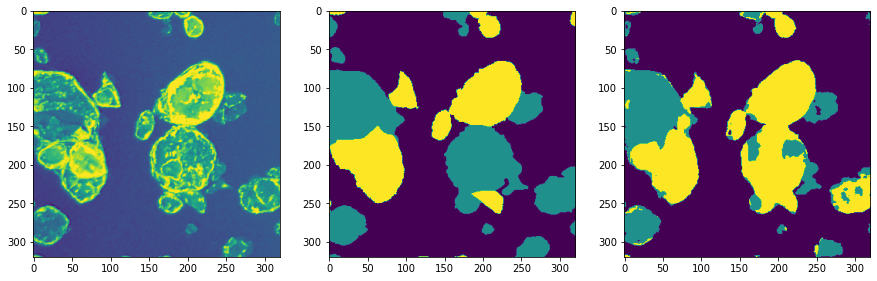

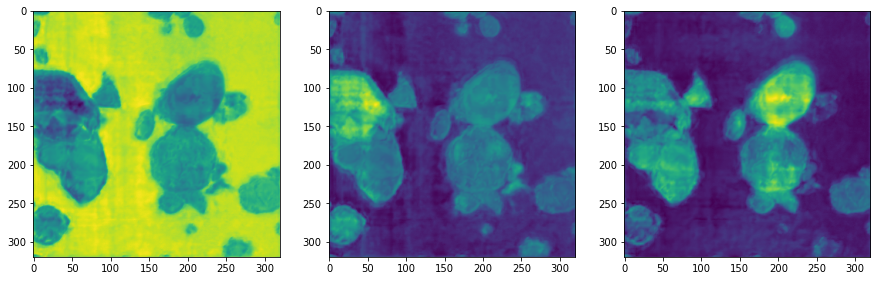

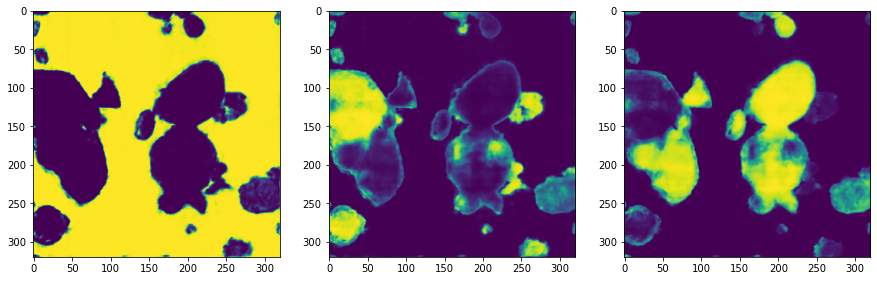

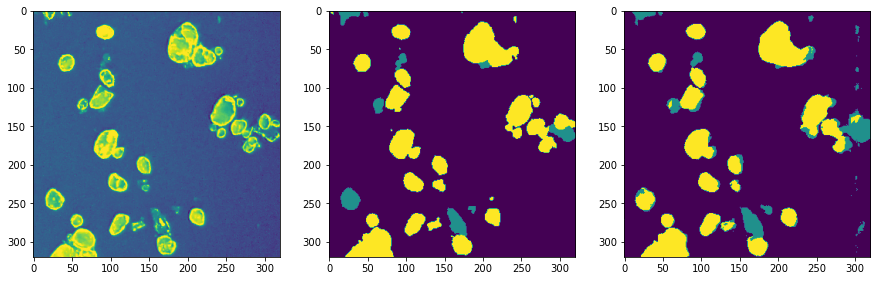

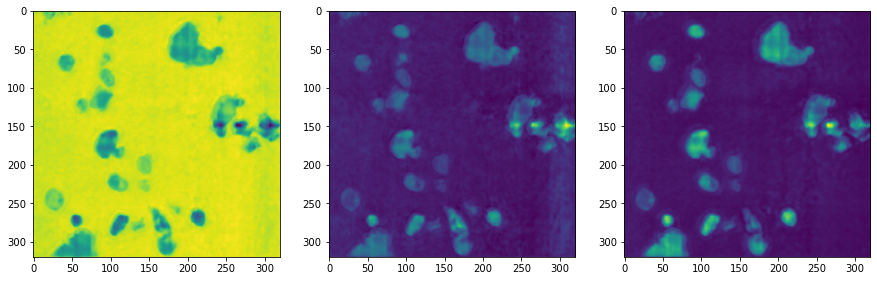

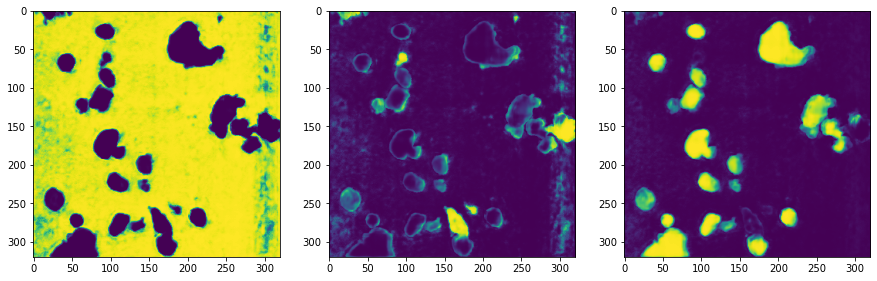

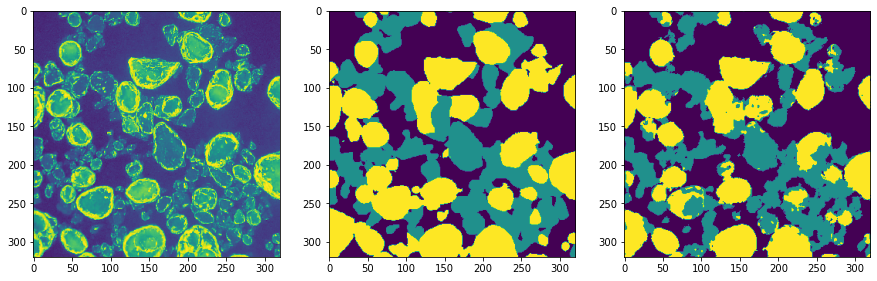

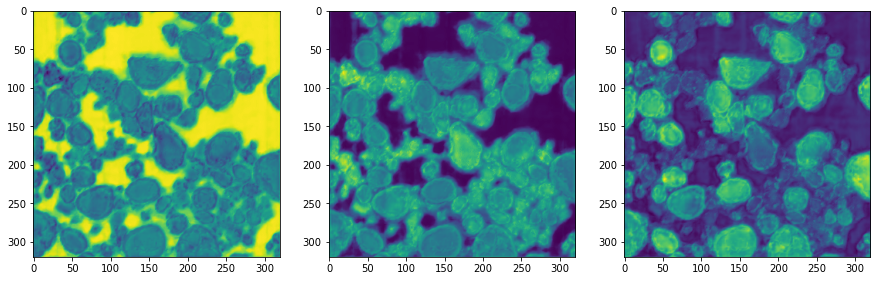

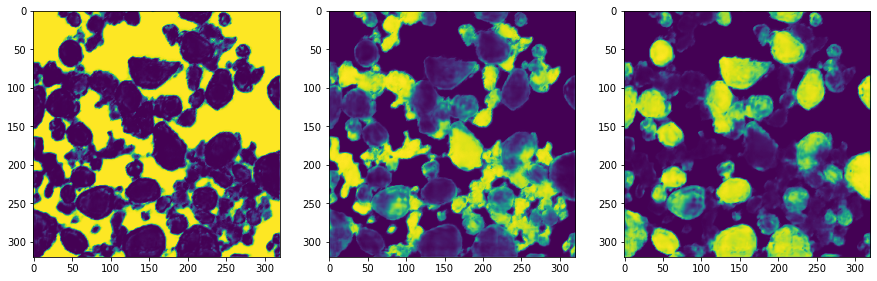

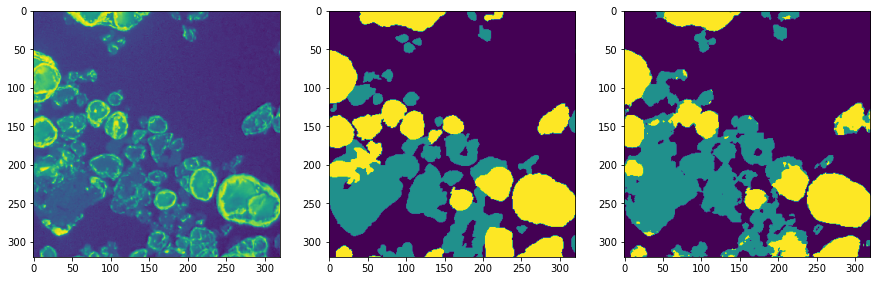

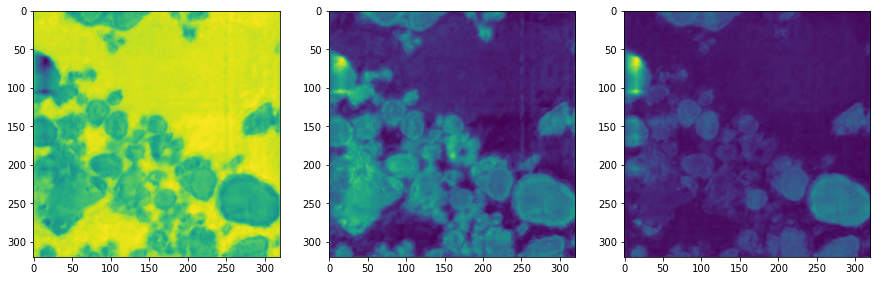

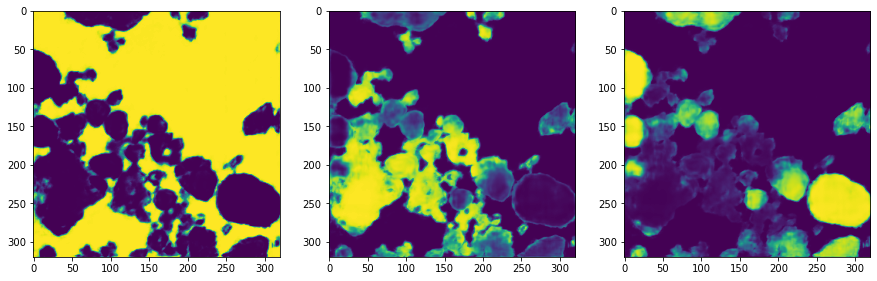

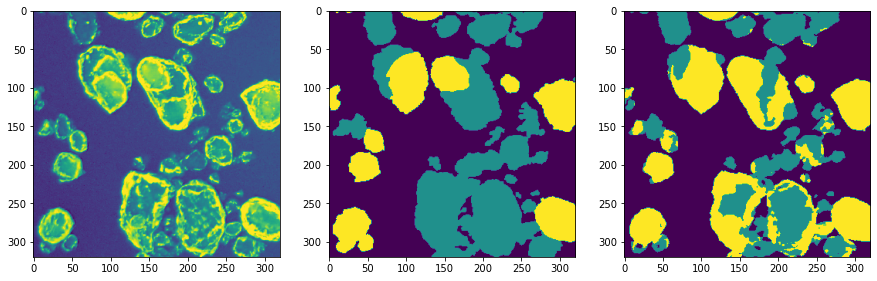

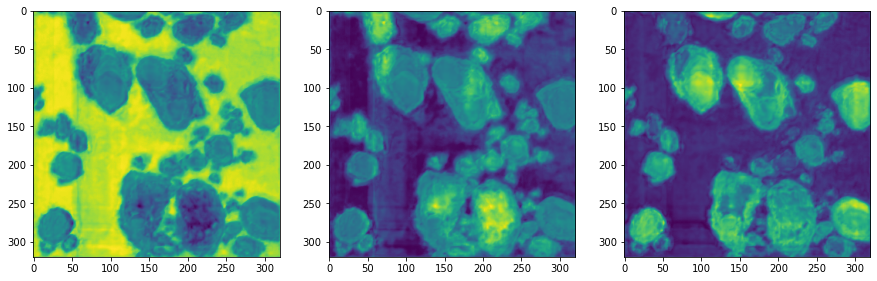

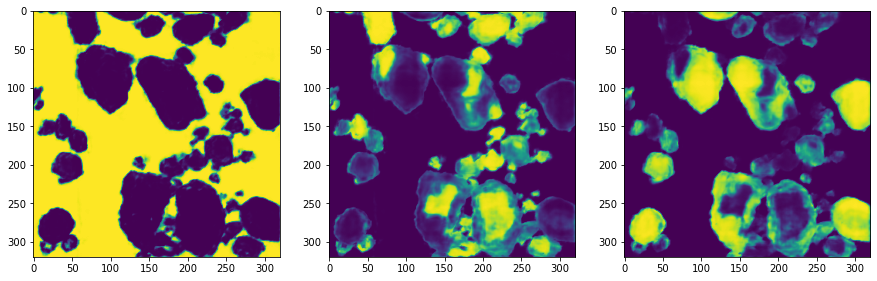

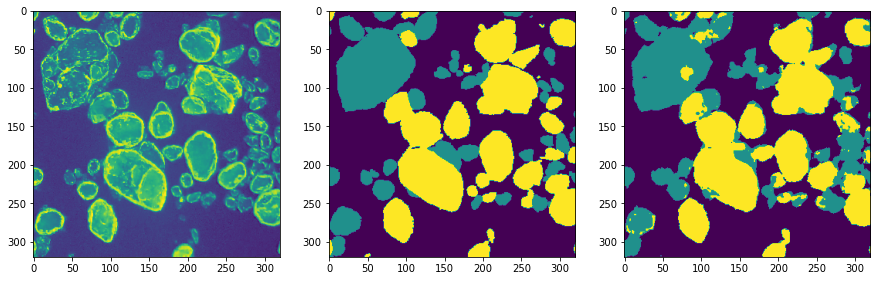

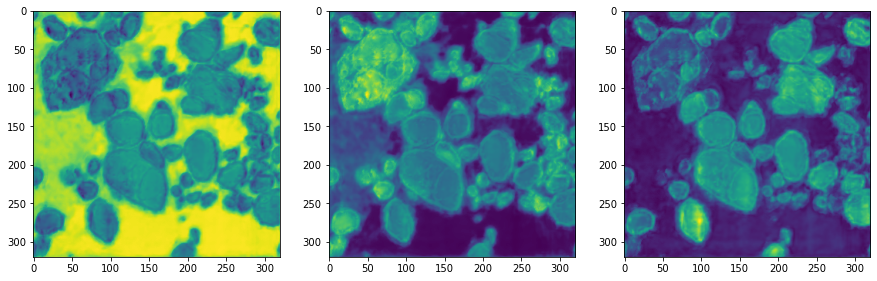

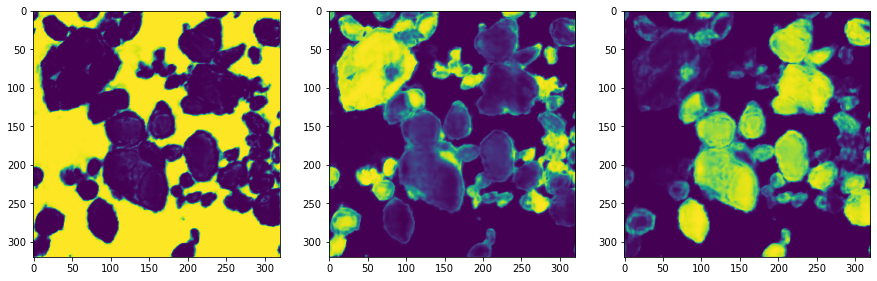

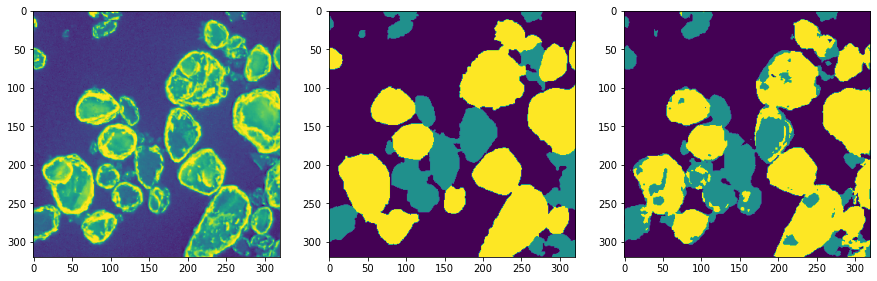

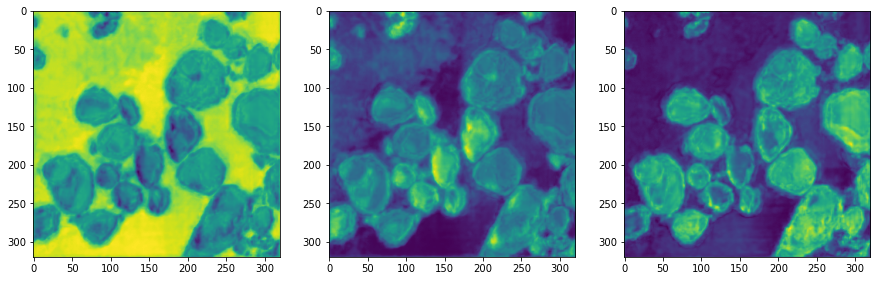

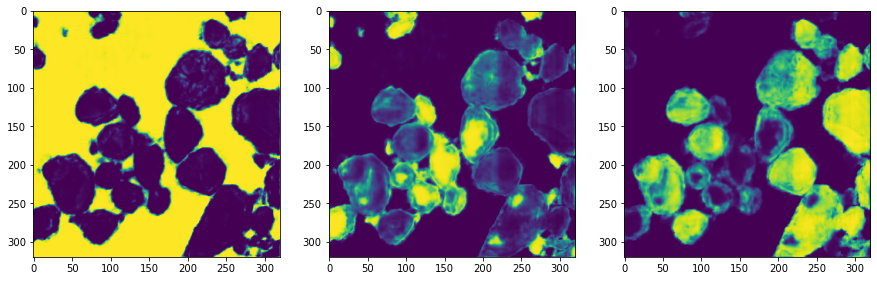

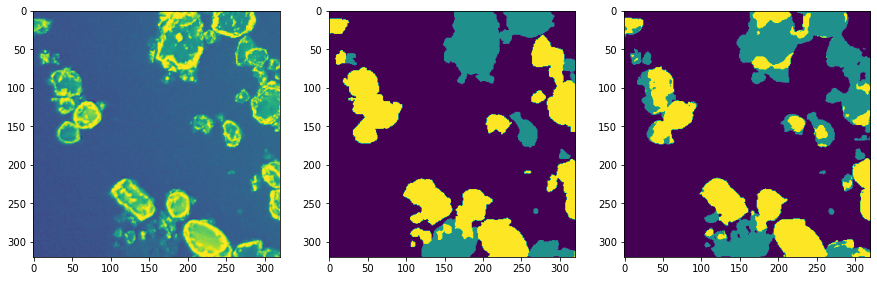

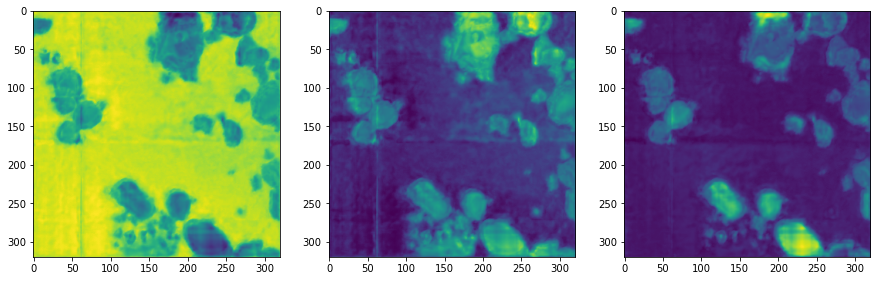

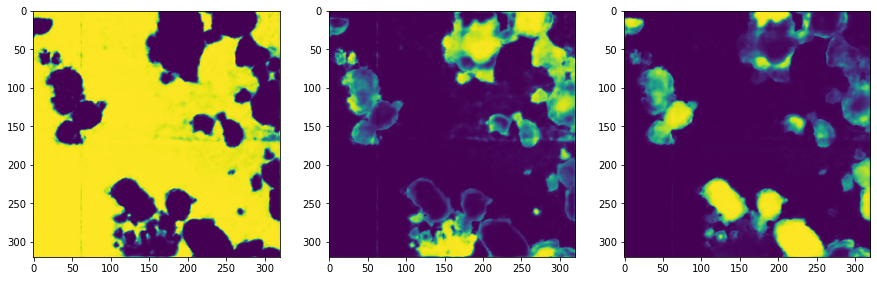

In [3]:
# model = BasicAxial(3, 3, 10).to(device=device)
# model = BasicAxialLBC_Add(3, 3, 10).to(device=device)
# model = TinyAxialUNetLBC(3, 3, 16, 4).to(device=device)
model = SmallAxialUNetLBC(3, 3, 10).to(device=device)
# model = BasicAxialLBC(3, 3, 10).to(device=device)
# model = UNet(n_channels=3, n_classes=3, bilinear=True).to(device=device)
# model = AxialUNet(3, 3, 10).to(device=device)
# model = AxialUNetLBC(3, 3, 10).to(device=device)
# model = AxialUNetSmall(3, 3, 10).to(device=device)
criterion = nn.CrossEntropyLoss()
tot = 0

model.load_state_dict(torch.load('/home/dsola/repos/PGA-Net/src/checkpoints/epoch20.pth', map_location=device))
model.train()
out = nn.Softmax(dim=1)

accs, ious, losses = [], [], []

for i, batch in enumerate(test_loader):
#     print(i)
    # batch = test_set[0]
    start = time.time()
    img = batch['image'].to(device=device)
    mask = batch['mask'].to(device=device, dtype=torch.long)

    with torch.no_grad():
        output = model(img)
    
    sftmx = out(output)
    argmx = torch.argmax(sftmx, dim=1)

    hist = _fast_hist(mask.squeeze(0).squeeze(0).to(dtype=torch.long), argmx.squeeze(0).to(dtype=torch.long), 3)
    losses.append(criterion(output, mask.squeeze(1)).item())

    accs.append(per_class_pixel_accuracy(hist))
    ious.append(jaccard_index(hist))

    fig, axs = plt.subplots(1,3, figsize=(15,15));
    axs[0].imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);
    axs[1].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());
    axs[2].imshow(argmx.squeeze(0).detach().cpu().numpy());
    
    fig, axs = plt.subplots(1,3, figsize=(15,15))
    axs[0].imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);
    axs[1].imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]);
    axs[2].imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]);
    
    fig, axs = plt.subplots(1,3, figsize=(15,15))
    axs[0].imshow(sftmx.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);
    axs[1].imshow(sftmx.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]);
    axs[2].imshow(sftmx.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]);
    end = time.time()
    tot += (end - start)
    print(f"Image finished in {end - start} seconds.")
    print(tot)

In [4]:
display_metric_list(accs, 'Accuracy')
display_metric_list(ious, 'IoU')

Mean water Accuracy: 0.962969958782196
Mean anchor Accuracy: 0.7438357472419739
Mean frazil Accuracy: 0.8327233195304871
Mean Accuracy: 0.8465096950531006
Mean water IoU: 0.9215447306632996
Mean anchor IoU: 0.5649415254592896
Mean frazil IoU: 0.7004480361938477
Mean IoU: 0.7289782166481018


In [5]:
print(np.mean(losses))

0.39902782887220384


In [5]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

51680


In [6]:
params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
#         print(name, param.numel())
        params += param.numel()
print(params)

28280


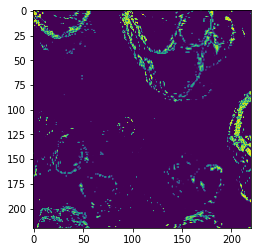

In [15]:
plt.imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]);

In [22]:
batch = test_set[5]
img = batch['image'].unsqueeze(0).to(device=device)
mask = batch['mask'].unsqueeze(0).to(device=device, dtype=torch.long)
prop = batch['prop'].unsqueeze(0).to(device=device, dtype=torch.long)

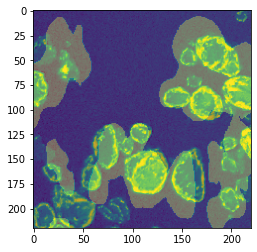

In [23]:
plt.figure()
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);
plt.imshow(prop.squeeze(0).squeeze(0).detach().cpu().numpy(), alpha=0.3);

In [13]:
output[0].shape

torch.Size([3, 220, 220])

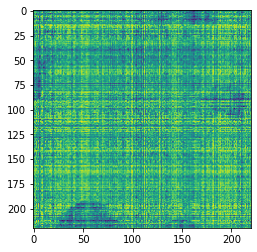

In [10]:
plt.imshow(output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

In [3]:
img = test_set[1]['image'].unsqueeze(0).to(device=device)
mask = test_set[1]['mask'].unsqueeze(0).to(device=device, dtype=torch.float32)
print(img.shape, mask.shape)

torch.Size([1, 3, 220, 220]) torch.Size([1, 1, 220, 220])


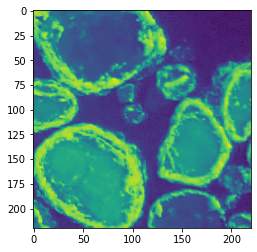

In [4]:
plt.imshow(img.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]);

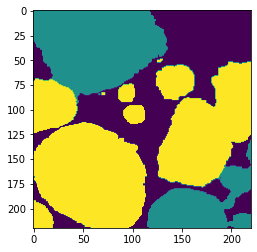

In [5]:
plt.imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());

In [6]:
model = BasicAxial(3, 3, 10, img_crop=img_crop).to(device=device)
model.load_state_dict(torch.load('../checkpoints/epoch20.pth', map_location=device))
model.eval()
output = model(img)

/home/dsola/anaconda3/envs/PGA-Net/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


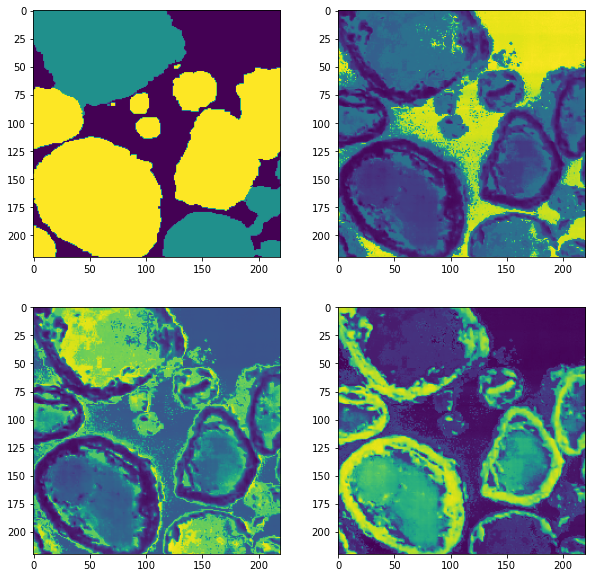

In [7]:
water = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
ice1 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
ice2 = output.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]

fix, axs = plt.subplots(2,2, figsize=(10,10))
axs[0][0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy())
axs[0][1].imshow((water))
axs[1][0].imshow((ice1))
axs[1][1].imshow((ice2))

torch.Size([1, 220, 220])


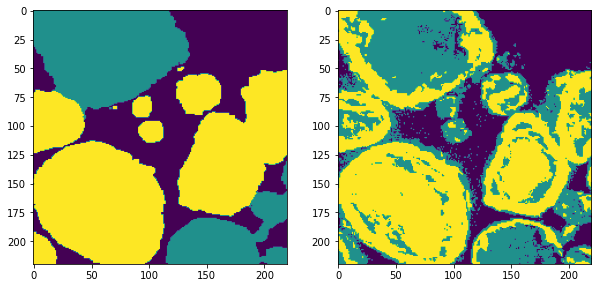

In [12]:
argmx = torch.argmax(output, dim=1)
print(argmx.shape)
fig, axs = plt.subplots(1,2, figsize=(10,10));
axs[0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy());
axs[1].imshow(argmx.squeeze(0).detach().cpu().numpy());

In [13]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

22200


In [23]:
water = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,0]
ice1 = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,1]
ice2 = probs.squeeze(0).permute(1,2,0).detach().cpu().numpy()[:,:,2]

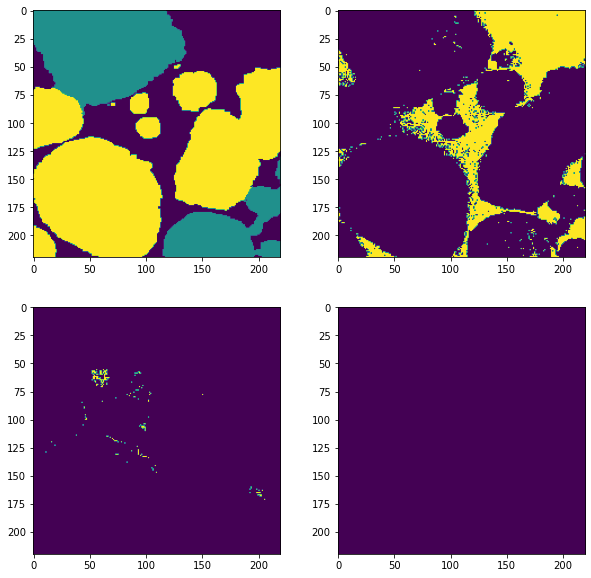

In [27]:
fix, axs = plt.subplots(2,2, figsize=(10,10))
axs[0][0].imshow(mask.squeeze(0).squeeze(0).detach().cpu().numpy())
axs[0][1].imshow((water>0.5))
axs[1][0].imshow((ice1>0.5))
axs[1][1].imshow((ice2>0.5))

In [16]:
np.unique(ice2)

array([6.1915780e-05, 8.1588587e-05, 8.1999642e-05, ..., 4.4421831e-01,
       4.4426095e-01, 4.4441947e-01], dtype=float32)